# Siamese Network with simulated scatter plot data.

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
import glob
from torchviz import *

In [2]:
POS_LABEL = 0 # Pair of Images that match
NEG_LABEL = 1 #Pair of Images that do not match
#If you reverse the labels, you have to change the Contrastive Loss function.
SZ = 128
MARGIN = 5.0

In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Make paired data with Dataset and DataLoader

In [4]:
class SiameseDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        name0 = img0_tuple[0]
        name1 = img1_tuple[0]
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        labels = torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        return img0, img1 , labels , name0, name1
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
dataset_folder = dset.ImageFolder('./data/mol_data/')
siamese_ds = SiameseDataset(imageFolderDataset = dataset_folder,
                            transform=transforms.Compose([transforms.Resize((SZ,SZ)),transforms.ToTensor()]),                             
                            should_invert=False)

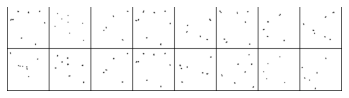

torch.Size([8, 1, 128, 128])


In [6]:
vis_dataloader = DataLoader(siamese_ds, shuffle=True, num_workers=8, batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[0].shape)

## Model

In [25]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*SZ*SZ, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def feature_extract(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)        
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.feature_extract(input1) #extract features from image0
        output2 = self.feature_extract(input2) #extract features from image1
        return output1, output2
    
    
net = SiameseNetwork()
print(net)

X0 = torch.zeros((2,1, SZ, SZ)) #channel first (after batch)
X1 = torch.zeros((2,1, SZ, SZ)) #channel first (after batch)
d1,d2 = net(X0,X1)
del net

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=131072, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)


## Contrastive Loss function

In [8]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=MARGIN):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        pred = (self.margin < euclidean_distance).type(torch.float)         
        return loss_contrastive, euclidean_distance, pred

## BCELoss (did not do well)

In [9]:
#did not work well, you can try by setting criterion = SimpleBCELoss() below.
class SimpleBCELoss(torch.nn.Module):
    
    def __init__(self):
        super(SimpleBCELoss,self).__init__()
        self.bce_loss = nn.BCELoss()
            
    def forward(self,output1,output2,label):
        edist = nn.PairwiseDistance(p=2,keepdim=True)(output1,output2)
        edist = torch.sigmoid(edist)
        loss_bce = self.bce_loss(edist,label)
        return loss_bce

## Create Siamese network and train

In [17]:
new_net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(new_net.parameters(),lr = 0.0005)

num_epochs = 50
batch_size = 64

train_dataloader = DataLoader(siamese_ds, shuffle=True, num_workers=8, batch_size=batch_size)

counter = []
loss_history = [] 
itr_no = 0

for epoch in range(num_epochs):
    epoch_loss = []  # Sum of training loss, no. of tokens
    epoch_accuracy = []
    
    for i, data in enumerate(train_dataloader,0):
        X0, X1, Y, _ , _ = data
        X0, X1, Y = X0.cuda(), X1.cuda() , Y.cuda()

        optimizer.zero_grad()
        
        output1,output2 = new_net(X0,X1)
        loss_contrastive, edist, predictions = criterion(output1,output2,Y)
        loss_contrastive.backward()
        
        optimizer.step()

        epoch_loss.append(loss_contrastive.item())
        acc = (Y==predictions).type(torch.float).cpu().numpy()
        epoch_accuracy.extend(acc)

    epoch_loss = np.mean(epoch_loss)
    print('epoch',epoch,'loss=',epoch_loss,'acc=',np.mean(epoch_accuracy))
    loss_history.append(epoch_loss)
    counter.append(epoch)

epoch 0 loss= 7.756827116012573 acc= 0.64
epoch 1 loss= 11.239495158195496 acc= 0.82
epoch 2 loss= 9.471995830535889 acc= 0.86
epoch 3 loss= 13.70376205444336 acc= 0.87
epoch 4 loss= 5.519943952560425 acc= 0.84
epoch 5 loss= 3.369861125946045 acc= 0.76
epoch 6 loss= 3.0218515396118164 acc= 0.73
epoch 7 loss= 2.9657337069511414 acc= 0.78
epoch 8 loss= 1.6079654693603516 acc= 0.78
epoch 9 loss= 3.131492257118225 acc= 0.85
epoch 10 loss= 2.4493545293807983 acc= 0.9
epoch 11 loss= 1.0936293005943298 acc= 0.95
epoch 12 loss= 1.4916363954544067 acc= 0.9
epoch 13 loss= 1.4245648682117462 acc= 0.96
epoch 14 loss= 1.2117842435836792 acc= 0.95
epoch 15 loss= 0.8686115443706512 acc= 0.94
epoch 16 loss= 0.8415320217609406 acc= 0.98
epoch 17 loss= 0.9453553855419159 acc= 0.97
epoch 18 loss= 1.2572665214538574 acc= 0.97
epoch 19 loss= 0.5006191581487656 acc= 0.99
epoch 20 loss= 0.5650071799755096 acc= 0.95
epoch 21 loss= 0.9705791771411896 acc= 0.9
epoch 22 loss= 0.6488142907619476 acc= 0.95
epoch 2

## Plot training loss

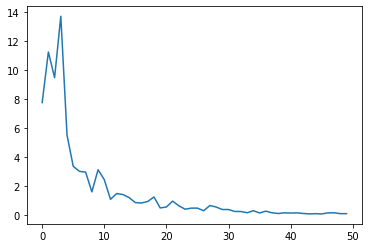

In [18]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    
show_plot(counter,loss_history)

## Visualize dynamic graph

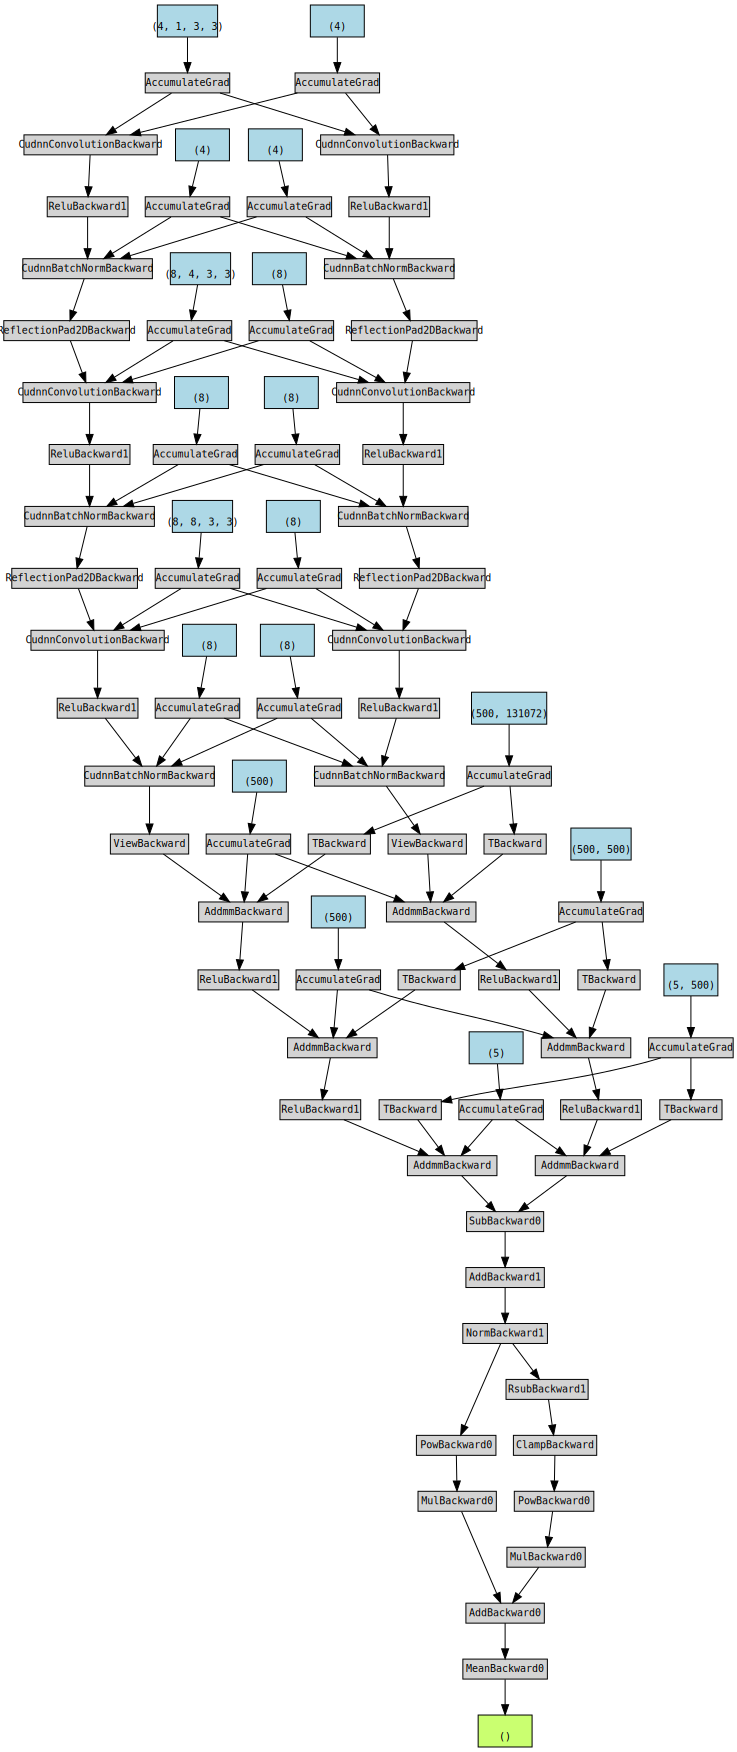

In [19]:
make_dot(loss_contrastive)

## Plot some images and their predictions

In [20]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(280, 10, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

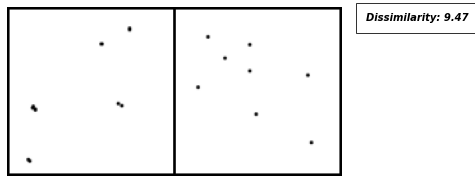

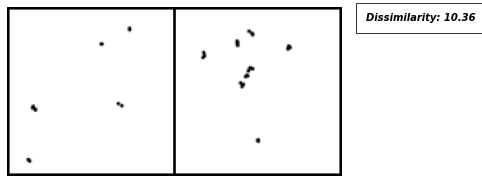

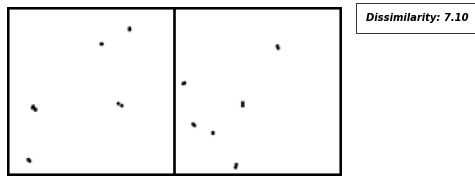

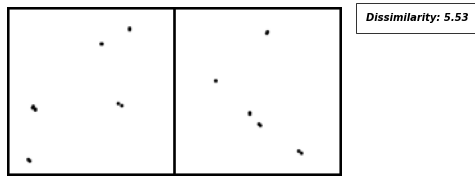

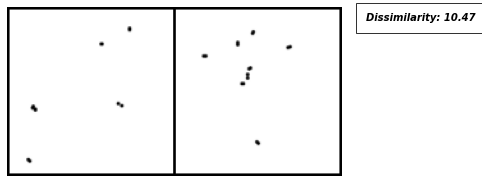

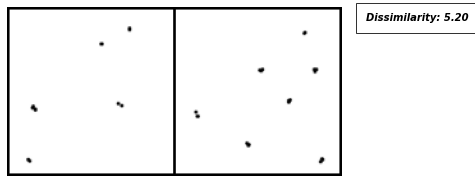

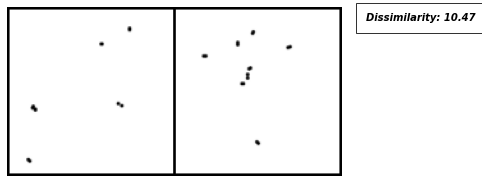

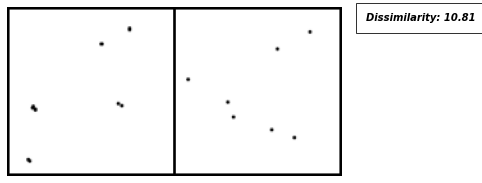

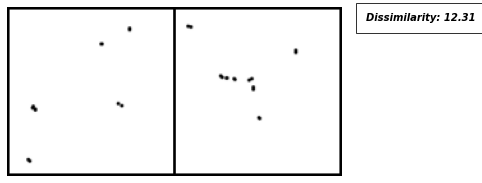

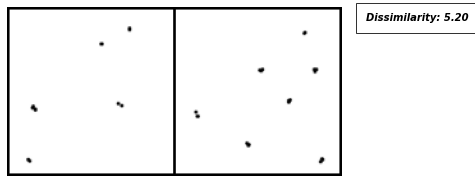

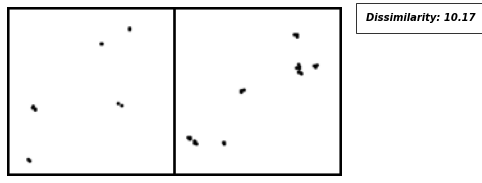

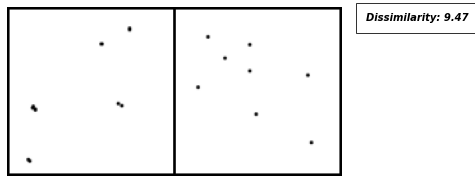

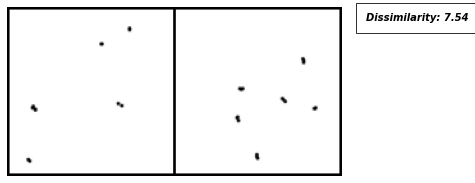

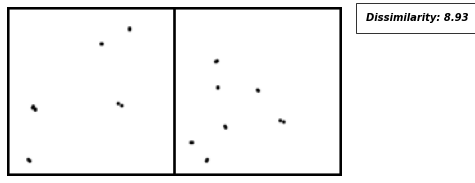

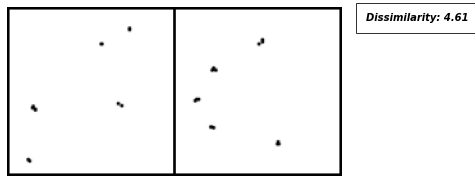

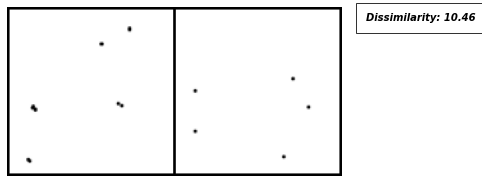

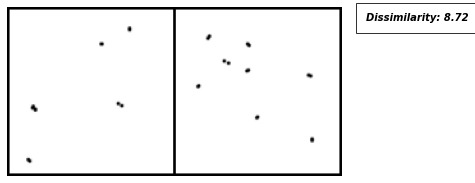

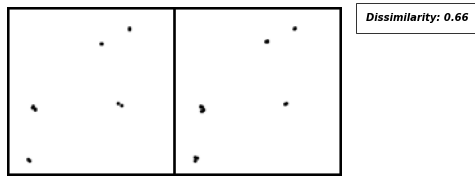

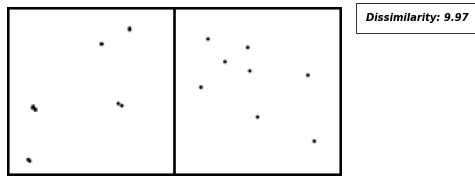

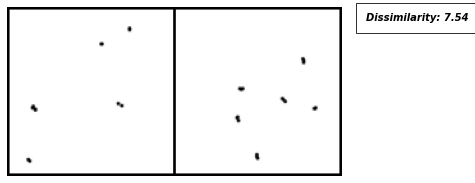

In [29]:
train_dataloader = DataLoader(siamese_ds, shuffle=True, num_workers=8, batch_size=1)
dataiter = iter(train_dataloader)
x0,_,_,_,_ = next(dataiter)

for i in range(20):
    _,x1,label2,_,_ = next(dataiter)
    concatenated = torch.cat((x0,x1),0)

    output1,output2 = new_net(x0.cuda(),x1.cuda())    
    
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))